In [114]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

In [115]:
data_reg=pd.read_excel('data_reg.xlsx')
data_class=pd.read_excel('data_class.xlsx')
data_reg_prep=pd.read_excel('data_reg_prep.xlsx')
data_class_prep=pd.read_excel('data_class_prep.xlsx')

data_reg_temp = data_reg.drop("SalePrice",axis = 1)
cols_temp = ["OverallQual","OverallCond","IsRemodGar","IsRemod"]
data_reg_temp[cols_temp]=data_reg_temp[cols_temp].astype("object")

cat_cols = data_reg_temp.select_dtypes(include = "object").columns.tolist()
print(len(cat_cols))
print(cat_cols)

num_cols = data_reg_temp.select_dtypes(include="number").columns.tolist()
print(len(num_cols))
print(num_cols)

Xtrain,Xtest,Ytrain,Ytest = train_test_split(data_reg_temp,data_reg["SalePrice"],test_size =0.3,random_state=0)
Xtrain = Xtrain.sort_index()
Xtest = Xtest.sort_index()
Ytrain= Ytrain.sort_index()
Ytest = Ytest.sort_index()

Xtrain_index = Xtrain.index.tolist()
Xtest_index = Xtest.index.tolist()

Xtrain_cat = Xtrain[cat_cols]

Xtrain_num = Xtrain[num_cols]
train_mean= Xtrain_num.mean()
train_std = np.sqrt(Xtrain_num.var())

Xtest_cat = Xtest[cat_cols]
Xtest_num = Xtest[num_cols]

Xtrain_num_std = Xtrain_num.apply(lambda x: (x - x.mean()) / np.sqrt(x.var())) 
Xtest_num_std = Xtest_num.copy()
for i in num_cols:
    Xtest_num_std[i] = (Xtest_num_std[i] - train_mean[i]) / train_std[i]

#axis = 0 caculate the mean or var through columns ,which is the default value in apply
# data_num_nor = data_num[numeric_cols].apply(lambda x: (x - x.min()) / (x.max(axis=0) - x.min(axis=0)))

#dummy的话最好一起dummy，因为有可能 test dataset 没有一些分类，导致train和test 的dummy的维度不一致

cat_dummy = data_reg_temp[cat_cols].copy()
for i in cat_cols:
    dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
    cat_dummy = pd.concat([cat_dummy,dummy_df], axis=1)
    cat_dummy = cat_dummy.drop(i, axis = 1)
print(cat_dummy.shape) 

Xtest_cat_dummy = cat_dummy.iloc[Xtest_index,:]
Xtrain_cat_dummy = cat_dummy.iloc[Xtrain_index,:]

Xtrain_lr = pd.concat((Xtrain_num_std,Xtrain_cat_dummy),axis = 1)
Xtest_lr = pd.concat((Xtest_num_std,Xtest_cat_dummy),axis = 1)
Ytrain_lr = Ytrain
Ytest_lr = Ytest

Xtrain_tree = pd.concat((Xtrain_num,Xtrain_cat),axis = 1)
Xtest_tree = pd.concat((Xtest_num,Xtest_cat),axis = 1)
Ytrain_tree = data_class.iloc[Xtrain_index,:]["PriceLevel"]
Ytest_tree = data_class.iloc[Xtest_index,:]["PriceLevel"]

20
['MSZoning', 'LotShape', 'HouseStyle', 'OverallQual', 'OverallCond', 'Exterior1st', 'MasVnrType', 'Foundation', 'BsmtQual', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageQual', 'PavedDrive', 'SaleType', 'SaleCondition', 'IsRemodGar', 'IsRemod']
9
['LotArea', 'YearBuilt', 'MasVnrArea', 'Fireplaces', 'GarAreaPerCar', 'GrLivAreaPerRoom', 'TotalHouseSF', 'TotalFullBath', 'TotalPorchSF']
(2930, 125)


C:\Users\T480S\AppData\Local\Temp\ipykernel_32012\353927329.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
C:\Users\T480S\AppData\Local\Temp\ipykernel_32012\353927329.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
C:\Users\T480S\AppData\Local\Temp\ipykernel_32012\353927329.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
C:\Users\T480S\AppData\Local\Temp\ipykernel_32012\353927329.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when pas

In [126]:
from sklearn.model_selection import KFold
reg = LR().fit(Xtrain_lr, Ytrain_lr)
yhat = reg.predict(Xtrain_lr)
kf = KFold(n_splits=5, shuffle=True, random_state=0)
lr_cv_rmse = np.sqrt(-1*cross_val_score(reg,Xtrain_lr,Ytrain_lr,cv=kf, scoring="neg_mean_squared_error"))
lr_cv_mae = -1*cross_val_score(reg,Xtrain_lr,Ytrain_lr,cv=kf,scoring="neg_mean_absolute_error")
lr_cv_r2 = cross_val_score(reg,Xtrain_lr,Ytrain_lr,cv=kf)
# print(lr_cv_rmse)
# print(lr_cv_mae)
# print(lr_cv_r2)
#print((abs((Ytrain_lr-yhat)).sum())/Ytrain_lr.shape[0])


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import matplotlib.pyplot as plt
print(np.sqrt(mse(Ytrain_lr,yhat)))
print(mae(Ytrain_lr,yhat))
print(r2(Ytrain_lr,yhat))

yhat1 = reg.predict(Xtest_lr)
indices = np.where(yhat1 > max(Ytest_lr) + 10000000)[0]
print("PPPP",indices)
# print([*zip(Ytest_lr,yhat1)])
# print((abs((Ytest_lr-yhat1)).sum())/Ytest_lr.shape[0])
# plt.plot(range(len(Ytest_lr-yhat1)),abs(Ytest_lr-yhat1))
# plt.show()
# plt.plot(range(len(Ytest_lr-yhat1)),abs(Ytest_lr))
# plt.show()
# plt.plot(range(len(Ytest_lr-yhat1)),abs(yhat1))
Xtest_lr.drop(Xtest_lr.index[indices],inplace=True)
Ytest_lr.drop(Ytest_lr.index[indices],inplace=True)
#indices是行号不是索引
#pd.concat(Xtest_lr.iloc[[201,672]:],Xtest_lr.iloc[201,:])

yhat1 = reg.predict(Xtest_lr)
print(np.sqrt(mse(Ytest_lr,yhat1)))
print(mae(Ytest_lr,yhat1))
print(r2(Ytest_lr,yhat1))




25915.02370616092
16411.01999024866
0.8906183860017083
PPPP []
35802.51614512474
19490.853881278537
0.8152417222879464


explained_variance_score(y_true, y_pred, sample_weight=None, multioutput=‘uniform_average’)：回归方差(反应自变量与因变量之间的相关程度)

mean_absolute_error(y_true,y_pred,sample_weight=None,
multioutput=‘uniform_average’)：
平均绝对误差

mean_squared_error(y_true, y_pred, sample_weight=None, multioutput=‘uniform_average’)：均方差

median_absolute_error(y_true, y_pred) 中值绝对误差

r2_score(y_true, y_pred,sample_weight=None,multioutput=‘uniform_average’) ：R平方值

In [76]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
print(mse(yhat1,Ytest_lr))
print(mae(yhat1,Ytest_lr))
print(r2(yhat1,Ytest_lr))

print(mse(yhat,Ytrain_lr))
print(mae(yhat,Ytrain_lr))
print(r2(yhat,Ytrain_lr))

cv_mae = cross_val_score(reg,Xtrain_lr,Ytrain_lr,cv=20,scoring="neg_mean_absolute_error")
print(cv_mae)
cv_index = np.where(cv_mae < - 1000000 )[0]
cv_mae= np.delete(cv_mae, cv_index)
print(cv_mae)
cv_mae = cv_mae.sum()/len(cv_mae)
-cv_mae

1281820162.3219178
19490.853881278537
0.785281030639833
671588453.6908824
16411.01999024866
0.8771880536590555
[-1.90478252e+04 -7.10358893e+12 -1.83018362e+04 -2.27682913e+04
 -1.48762476e+04 -1.15778173e+13 -1.24131847e+14 -1.95248495e+04
 -1.45543689e+04 -2.37475212e+13 -4.95302194e+13 -2.53938529e+04
 -1.88426765e+04 -1.49696176e+04 -9.56698092e+10 -4.65609862e+13
 -2.02813137e+04 -1.53185441e+12 -1.89952148e+13 -2.17688952e+14]
[-19047.82524272 -18301.83616505 -22768.29126214 -14876.24757282
 -19524.84951456 -14554.36893204 -25393.85294118 -18842.67647059
 -14969.61764706 -20281.31372549]


-18856.087947363412

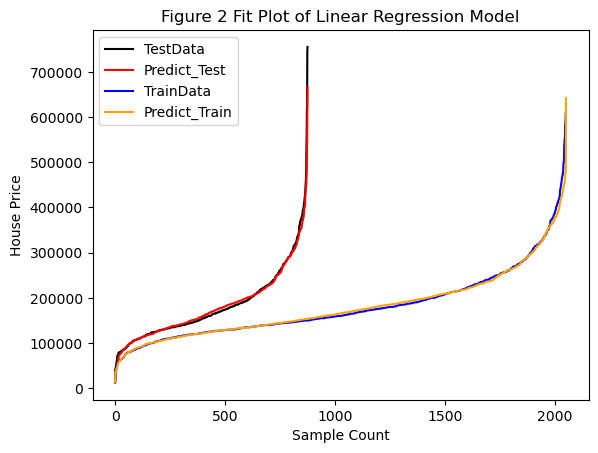

In [129]:
plt.plot(range(len(Ytest)),sorted(Ytest_lr),c="black",label= "TestData")
plt.plot(range(len(yhat1)),sorted(yhat1),c="red",label = "Predict_Test")
plt.plot(range(len(Ytrain)),sorted(Ytrain_lr),c="Blue",label= "TrainData")
plt.plot(range(len(yhat)),sorted(yhat),c="orange",label= "Predict_Train")
plt.title("Figure 2 Fit Plot of Linear Regression Model",fontsize=12)
plt.xlabel("Sample Count")
plt.ylabel("House Price")
plt.legend()
plt.show()

# ridge

In [82]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso

reg = Ridge(alpha=1).fit(Xtrain_lr,Ytrain_lr)
reg.score(Xtest_lr,Ytest_lr)


cv_mae = cross_val_score(reg,Xtrain_lr,Ytrain_lr,cv=20,scoring="neg_mean_absolute_error")
print(cv_mae)
cv_index = np.where(cv_mae < - 1000000 )[0]
cv_mae= np.delete(cv_mae, cv_index)
print(cv_mae)
cv_mae = cv_mae.sum()/len(cv_mae)
-cv_mae




[-19053.27633431 -14762.85500934 -18330.2737478  -22697.16155168
 -14760.21546916 -16296.99990745 -16465.9009908  -19315.34318108
 -14273.16603578 -14725.53371136 -23267.45113954 -25434.70497511
 -18741.08109556 -14829.79202742 -16276.2597769  -20555.78479327
 -20149.64616425 -13825.22385888 -15649.84255229 -19507.23000214]
[-19053.27633431 -14762.85500934 -18330.2737478  -22697.16155168
 -14760.21546916 -16296.99990745 -16465.9009908  -19315.34318108
 -14273.16603578 -14725.53371136 -23267.45113954 -25434.70497511
 -18741.08109556 -14829.79202742 -16276.2597769  -20555.78479327
 -20149.64616425 -13825.22385888 -15649.84255229 -19507.23000214]


17945.887116205682

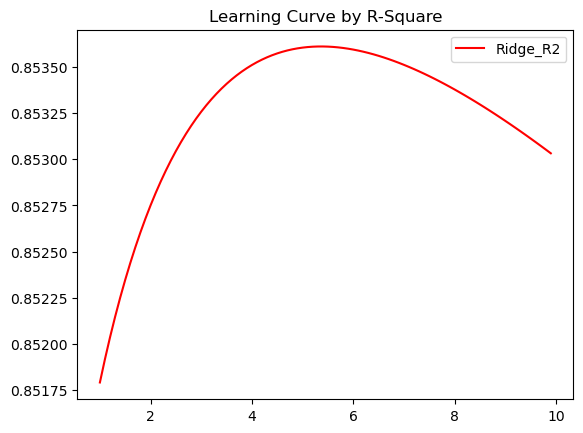

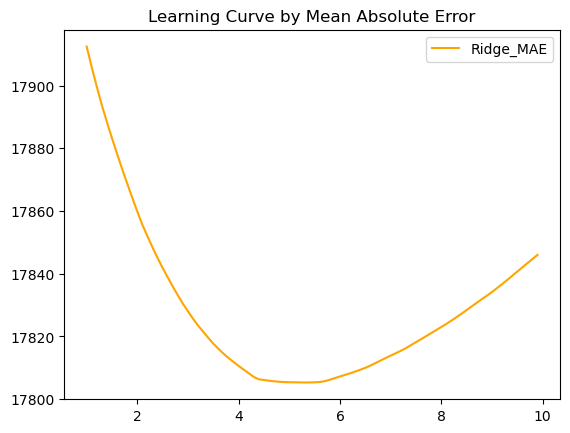

1268178096.983446
19352.821805359363
0.7870572619055629


In [131]:
alpharange = np.arange(1,20,0.1)
ridge_r2=[]
ridge_mae=[]
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    regs_r2 = cross_val_score(reg,Xtrain_lr,Ytrain_lr,cv=10,scoring = "r2").mean()
    regs_mae = cross_val_score(reg,Xtrain_lr,Ytrain_lr,cv=10,scoring = "neg_mean_absolute_error").mean()
    ridge_r2.append(regs_r2)
    ridge_mae.append(-regs_mae)
plt.plot(alpharange,ridge_r2,color="red",label="Ridge_R2")
plt.title("Learning Curve by R-Square")
plt.legend()
plt.show()
plt.plot(alpharange,ridge_mae,color="orange",label="Ridge_MAE")
plt.title("Learning Curve by Mean Absolute Error")
plt.legend()
plt.show()

reg = Ridge(alpha=1).fit(Xtrain_lr,Ytrain_lr)
yhat1 = reg.predict(Xtest_lr)
print(mse(yhat1,Ytest_lr))
print(mae(yhat1,Ytest_lr))
print(r2(yhat1,Ytest_lr))

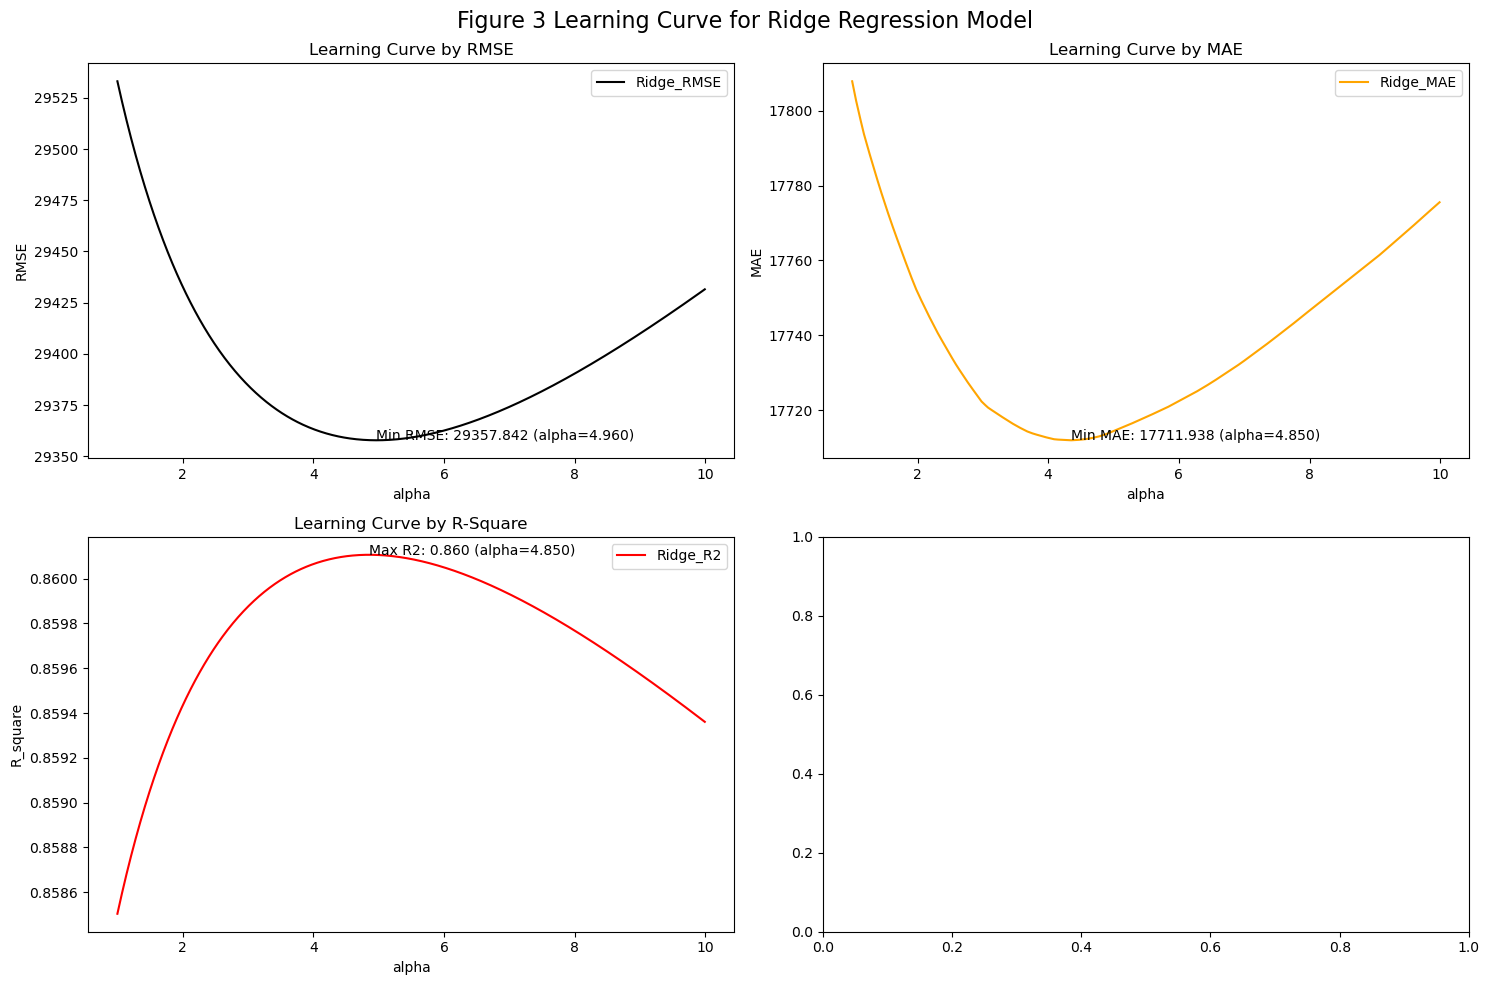

In [149]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

alpharange = np.arange(1, 10, 0.01)
ridge_r2 = []
ridge_mae = []
ridge_rmse = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for alpha in alpharange:
    reg = Ridge(alpha=alpha)
    regs_r2 = cross_val_score(reg, Xtrain_lr, Ytrain_lr, cv=kf, scoring="r2").mean()
    regs_mae = cross_val_score(reg, Xtrain_lr, Ytrain_lr, cv=kf, scoring="neg_mean_absolute_error").mean()
    regs_rmse = np.sqrt(-cross_val_score(reg, Xtrain_lr, Ytrain_lr, cv=kf, scoring="neg_mean_squared_error").mean())
    ridge_r2.append(regs_r2)
    ridge_mae.append(-regs_mae)
    ridge_rmse.append(regs_rmse)
# Create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Figure 3 Learning Curve for Ridge Regression Model", fontsize=16)
# Plot the R2 curve
axs[1,0].plot(alpharange, ridge_r2, color="red", label="Ridge_R2")
axs[1,0].set_title("Learning Curve by R-Square")
axs[1,0].legend()
axs[1,0].set_xlabel("alpha")
axs[1,0].set_ylabel("R_square")
# Plot the MAE curve
axs[0,1].plot(alpharange, ridge_mae, color="orange", label="Ridge_MAE")
axs[0,1].set_title("Learning Curve by MAE")
axs[0,1].legend()
axs[0,1].set_xlabel("alpha")
axs[0,1].set_ylabel("MAE")

axs[0,0].plot(alpharange, ridge_rmse, color="black", label="Ridge_RMSE")
axs[0,0].set_title("Learning Curve by RMSE")
axs[0,0].legend()
axs[0,0].set_xlabel("alpha")
axs[0,0].set_ylabel("RMSE")
# Find the maximum R2 value and annotate it on the R2 plot
max_r2_alpha = alpharange[np.argmax(ridge_r2)]
max_r2 = np.max(ridge_r2)
axs[1,0].annotate(f"Max R2: {max_r2:.3f} (alpha={max_r2_alpha:.3f})", xy=(max_r2_alpha, max_r2))                

# Find the minimum MAE value and annotate it on the MAE plot
min_mae_alpha = alpharange[np.argmin(ridge_mae)]
min_mae = np.min(ridge_mae)
axs[0,1].annotate(f"Min MAE: {min_mae:.3f} (alpha={max_r2_alpha:.3f})", xy=(min_mae_alpha, min_mae))

min_rmse_alpha = alpharange[np.argmin(ridge_rmse)]
min_rmse = np.min(ridge_rmse)
axs[0,0].annotate(f"Min RMSE: {min_rmse:.3f} (alpha={min_rmse_alpha:.3f})", xy=(min_rmse_alpha, min_rmse))

plt.tight_layout()
plt.show()

In [150]:

reg = Ridge(alpha=4.85).fit(Xtrain_lr,Ytrain_lr)
yhat1 = reg.predict(Xtest_lr)
print(np.sqrt(mse(Ytest_lr,yhat1)))
print(mae(Ytest_lr,yhat1))
print(r2(Ytest_lr,yhat1))

35532.71926026478
19330.663054122975
0.8180157949743685


d:\working software\Anaconda3\envs\bigdata\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e+11, tolerance: 1.147e+09
  model = cd_fast.enet_coordinate_descent(
d:\working software\Anaconda3\envs\bigdata\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e+11, tolerance: 1.027e+09
  model = cd_fast.enet_coordinate_descent(
d:\working software\Anaconda3\envs\bigdata\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

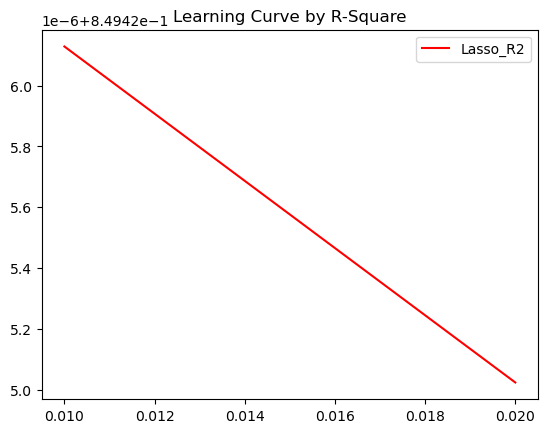

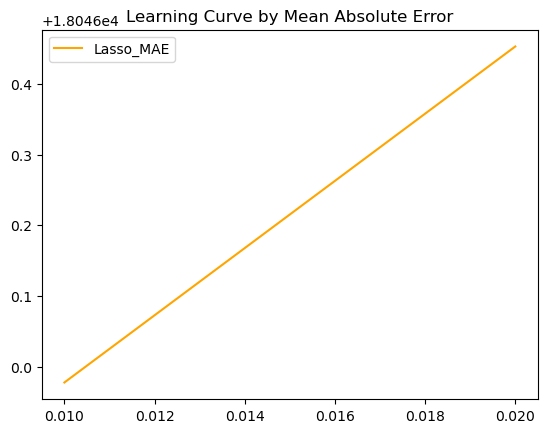

1281702642.741312
19490.451357965452
0.7852934151563224


d:\working software\Anaconda3\envs\bigdata\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e+11, tolerance: 1.259e+09
  model = cd_fast.enet_coordinate_descent(


In [101]:
alpharange = [0.01,0.02]
Lasso_r2=[]
Lasso_mae=[]
for alpha in alpharange:
    reg = Lasso(alpha=alpha)
    regs_r2 = cross_val_score(reg,Xtrain_lr,Ytrain_lr,cv=10,scoring = "r2").mean()
    regs_mae = cross_val_score(reg,Xtrain_lr,Ytrain_lr,cv=10,scoring = "neg_mean_absolute_error").mean()
    Lasso_r2.append(regs_r2)
    Lasso_mae.append(-regs_mae)
plt.plot(alpharange,Lasso_r2,color="red",label="Lasso_R2")
plt.title("Learning Curve by R-Square")
plt.legend()
plt.show()
plt.plot(alpharange,Lasso_mae,color="orange",label="Lasso_MAE")
plt.title("Learning Curve by Mean Absolute Error")
plt.legend()
plt.show()

reg = Lasso(alpha=0.1).fit(Xtrain_lr,Ytrain_lr)
yhat1 = reg.predict(Xtest_lr)
print(mse(yhat1,Ytest_lr))
print(mae(yhat1,Ytest_lr))
print(r2(yhat1,Ytest_lr))

In [106]:
from sklearn.preprocessing import PolynomialFeatures

xxx = PolynomialFeatures(degree=2).fit_transform(Xtrain_lr)
xxx.shape

reg = LR().fit(xxx, Ytrain_lr)
yhat = reg.predict(xxx)
print(mae(yhat,Ytrain_lr))

2305.3459630972698


0.9961584556923209
4073308709075.686
-0.004165271478812738
4073308709075.686


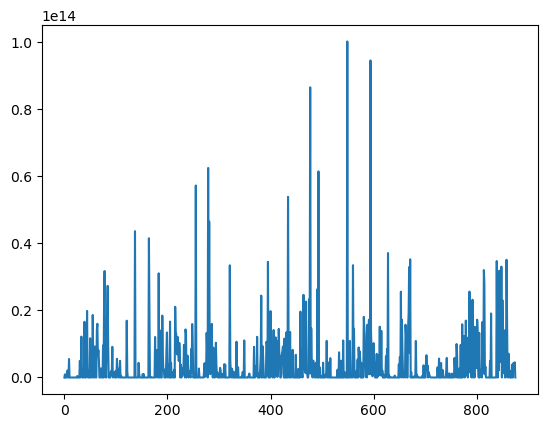

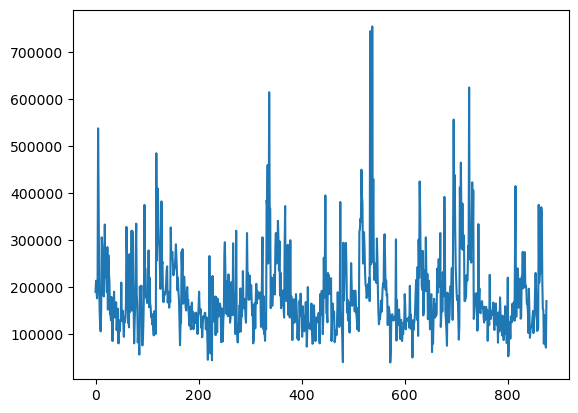

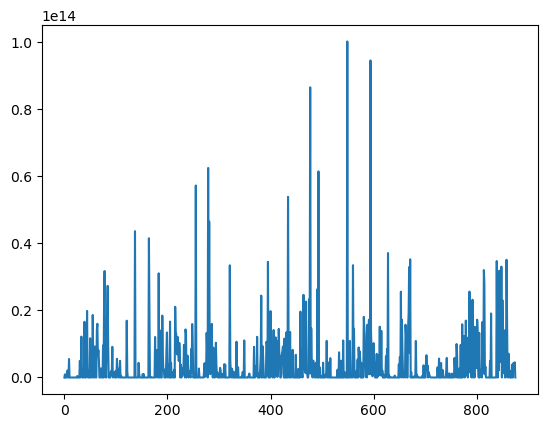

In [112]:
print(r2(yhat,Ytrain_lr))

xx_test =PolynomialFeatures(degree=2).fit_transform(Xtest_lr)
yhat1 = reg.predict(xx_test)

print(mae(yhat1,Ytest_lr))
print(r2(yhat1,Ytest_lr))

print((abs((Ytest_lr-yhat1)).sum())/Ytest_lr.shape[0])
plt.plot(range(len(Ytest_lr-yhat1)),abs(Ytest_lr-yhat1))
plt.show()
plt.plot(range(len(Ytest_lr-yhat1)),abs(Ytest_lr))
plt.show()
plt.plot(range(len(Ytest_lr-yhat1)),abs(yhat1))

# cv_index = np.where(mae(yhat1,Ytest_lr) < - 1000000 )[0]
# cv_mae= np.delete(cv_mae, cv_index)
# print(cv_mae)
# cv_mae = cv_mae.sum()/len(cv_mae)
# -cv_mae